In [31]:
import FinanceDataReader as fdr
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

def getCloseData(ticker, start, end=None):
    """
    종가 데이터
    ticker: 종목 번호
    start: 시작일
    end: 마지막 날짜
    return: 종목의 종가 데이터
    """
    return fdr.DataReader(ticker, start, end)['Close']

def getDayReturn(closeDataSet):
    """
    개별종목 일별 수익률
    closeDataSet: 종가 데이터
    return: 종가 데이터의 일별 수익률
    """
    return (closeDataSet / closeDataSet.shift(1)).fillna(1)

def getCumulativeReturn(closeDataSet):
    """
    개별종목 누적수익률 == 자산흐름
    closeDataSet: 종가 데이터
    return:종가데이터 누적수익률
    """
    return closeDataSet / closeDataSet.iloc[0]

def getPortfolioResult(closeDataSet, weight=None):
    """
    포트폴리오 결과
    closeDataSet: 종가 데이터
    weight: 포트폴리오 개별자산 비중
    return: 포트폴리오 일간수익률, 누적수익률
    """
    # 개별종목 일별 수익률
    dayReturn = getDayReturn(closeDataSet)
    # 개별종목 누적 수익률
    cumulativeReturn = getCumulativeReturn(closeDataSet)
    # 자산별 비중. 기본값: 동일비중
    if not weight:
        weight = [1/len(closeDataSet.columns)] * len(closeDataSet.columns)

    # 포트폴리오 누적 수익률
    portfolioCumulativeReturn = (weight * cumulativeReturn).sum(axis=1)
    # 포트폴리오 일별 수익률
    portfolioDayReturn = (portfolioCumulativeReturn / portfolioCumulativeReturn.shift(1)).fillna(1)
    return portfolioDayReturn, portfolioCumulativeReturn

def getEvaluation(cumulativeReturn):
    """
    cagr, dd, mdd
    투자 성과 지표
    """
    # cagr
    cagr = cumulativeReturn.iloc[-1] ** (252/len(cumulativeReturn))
    # mdd
    dd = (cumulativeReturn.cummax() - cumulativeReturn) / cumulativeReturn.cummax() * 100
    mdd= dd.max()

    print(f"최종 수익률: {cumulativeReturn.iloc[-1]}\ncagr: {cagr}\nmdd: {mdd}")

    return cagr, dd, mdd

def getRebalancingDate(closeDataSet, period="month"):
    """
    리밸런싱 일자 추출
    월별, 분기별, 연별
    """
    data = closeDataSet.copy()
    data = pd.DataFrame(data)
    data.index = pd.to_datetime(data.index)
    data['year'] = data.index.year
    data['month'] = data.index.month

    if period == "month":
        rebalancingDate = data.drop_duplicates(['year', 'month'], keep="last").index

    if period == "quarter":
        # 3 6 9 12월 말에 리밸런싱
        # np where 같은걸로 3, 6, 9, 12월 데이터만 가져오고
        # drop_duplicates keep last 하면 됌
        quarter = [3,6,9,12]
        data = data.loc[data['month'].isin(quarter)]
        rebalancingDate = data.drop_duplicates(['year', 'month'], keep="last").index

    if period == "year":
        rebalancingDate = data.drop_duplicates(['year'], keep="last").index

    return rebalancingDate

def getRebalancingPortfolioResult(closeDataSet, period = "month", weightDf=None):
    """
    리밸런싱 포트폴리오 결과
    closeDataSet: 종가 데이터
    weight: 포트폴리오 개별자산 비중
    return: 포트폴리오 일간수익률, 누적수익률
    """

    # 자산별 비중. 기본값: 동일비중
    if weightDf is None:
        rebalancingDate = getRebalancingDate(closeDataSet, period) # 리밸런싱 날짜
        weightDf = pd.DataFrame([[1/len(closeDataSet.columns)] * len(closeDataSet.columns)] * len(rebalancingDate),
                                index=rebalancingDate,
                                columns=closeDataSet.columns)
    # 자산별 비중이 있는 경우
    else:
        closeDataSet = closeDataSet.loc[weightDf.index[0]:]
        rebalancingDate = weightDf.index # 리밸런싱 날짜

    portfolio = pd.DataFrame() # 빈 데이터 프레임 생성

    totalAsset = 1 # 총 자산, 초기값 1
    start = rebalancingDate[0] # 리밸런싱 날짜, 초기값 첫 투자일

    for end in rebalancingDate[1:]:
        weight = weightDf.loc[start] # 당월 리밸런싱 비율
        priceData = closeDataSet.loc[start:end] # 당월 가격 데이터
        cumReturn = getCumulativeReturn(priceData) # 당월 누적 수익률
        weightedCumReturn = weight * cumReturn # 당월 리밸런싱 비율이 반영된 누적 수익률
        netCumReturn = totalAsset * weightedCumReturn # 전월 투자 결과 반영

        start = end # start 갱신
        totalAsset = netCumReturn.iloc[-1].sum() # 총 자산 갱신
        portfolio = pd.concat([portfolio, netCumReturn]) # 매월 데이터 추가

    portfolio = portfolio.loc[~portfolio.index.duplicated(keep='last')] # 중복 데이터 제거
    portfolioCumulativeReturn = portfolio.sum(axis=1) # 포트폴리오 누적 수익률
    portfolioDayReturn = (portfolioCumulativeReturn / portfolioCumulativeReturn.shift(1)).fillna(1) # 포트폴리오 일간 수익률

    return portfolioDayReturn, portfolioCumulativeReturn

def getWeightByAvgMomentumScore(closeDataSet, n = 12):
    """
    평균 모멘텀 스코어를 기반으로 한 투자 비중 구하기
    closeDataSet: 종가 데이터
    n: 모멘텀 기간 1~n
    return: 투자비중 weight df, 평균모멘텀 스코어 df
    """
    avgMomentumScore = 0 # 평모스 초기값
    priceOnRebalDate = closeDataSet.loc[getRebalancingDate(closeDataSet)] # 리밸런싱 일자의 가격 데이터

    # 1 ~ n개월 모멘텀 스코어 합
    for i in range(1, n+1):
        avgMomentumScore = np.where(priceOnRebalDate / priceOnRebalDate.shift(i) > 1, 1, 0) + avgMomentumScore

    # 평모스 계산
    avgMomentumScore = pd.DataFrame(avgMomentumScore, index=priceOnRebalDate.index, columns=priceOnRebalDate.columns) # dataframe 형변환
    avgMomentumScore = avgMomentumScore / n

    # 모멘텀 스코어에 따른 weight 계산
    weight = avgMomentumScore.divide(avgMomentumScore.sum(axis=1), axis=0).fillna(0)
    # 투자 비중이 모두 0인 구간에서는 현금 보유
    weight['cash'] = np.where(weight.sum(axis=1) == 0, 1, 0)

    # 투자비중, 평모스 리턴
    return weight, avgMomentumScore


# 리밸런싱
### 리밸런싱 개념

지금까지 배운 방법은 Buy & Hold 전략.  
결국 장기적인 관점에서 자산 가치는 우상향하게 되어있기 때문에 가격의 흔들림에 굴하지 않고 기다리는 전략임)
아주 오랜시간 기다려야하고. 중간중간 큰 낙폭이 오면 그대로 맞아야 하는 단점이 있음
  
이번에 배워볼 기법은 리밸런싱 으로, 리밸런싱이란 주기적으로 자산간 비중을 조절하는 것입니다.  
리밸런싱을 하는 이유는, 중간중간 적당한 차익을 실현하기 위함임  
__일반적으로 시장은 횡보와 추세를 계속 반복하기 때문에 리밸런싱 효과를 어느정도 누리는게 일반적으로 검증됨__
조금 더 고급진 표현으로는 고평가 된 자산을 일부 매도해서 저평가 된 자산을 매수하기 위해서 입니다.  
이렇게 리밸런싱 통해 일종에 고점 매도와 저점 매수효과를 어느정도 누릴 수 있게 되는 것입니다.

#### 리밸런싱 기법을 코드로 구현하기

In [4]:
# 더미데이터
closeDataSet = pd.DataFrame(
    {
        "kodex200": [100, 140, 120, 110, 100, 120, 110, 115, 120],
        "kodex10Bond": [100, 90, 105, 115, 125, 130, 120, 125, 130],
    },
    index=pd.to_datetime(["2022-01-31", "2022-02-10", "2022-02-21", "2022-02-28", "2022-03-10", "2022-03-19", "2022-03-31", "2022-04-20", "2022-04-30",])
)
closeDataSet

,kodex200,kodex10Bond
2022-01-31,100,100
2022-02-10,140,90
2022-02-21,120,105
2022-02-28,110,115
2022-03-10,100,125
2022-03-19,120,130
2022-03-31,110,120
2022-04-20,115,125
2022-04-30,120,130


### 리밸런싱 날짜 계산

In [5]:
# 매달 마지막 영업일

copyCloseDataSet = closeDataSet.copy()

copyCloseDataSet['year'] = copyCloseDataSet.index.year
copyCloseDataSet['month'] = copyCloseDataSet.index.month

copyCloseDataSet

,kodex200,kodex10Bond,year,month
2022-01-31,100,100,2022,1
2022-02-10,140,90,2022,2
2022-02-21,120,105,2022,2
2022-02-28,110,115,2022,2
2022-03-10,100,125,2022,3
2022-03-19,120,130,2022,3
2022-03-31,110,120,2022,3
2022-04-20,115,125,2022,4
2022-04-30,120,130,2022,4


In [7]:
# 원하는 비중으로 넣어도 되지만, 우선 동일비중으로 가정
defaultWeight = [1/len(closeDataSet.columns)] * len(closeDataSet.columns) # [1/n, 1/n ~~~]
defaultWeight

[0.5, 0.5]

In [46]:
rebalancingDate = copyCloseDataSet.drop_duplicates(['year','month'], keep="last").index
rebalancingDate

DatetimeIndex(['2022-01-31', '2022-02-28', '2022-03-31', '2022-04-30'], dtype='datetime64[ns]', freq=None)

### 리밸런싱 비중 계산

In [8]:
# 원하는 비중으로 넣어도 되지만, 우선 동일비중으로 가정
defaultWeight = [1/len(closeDataSet.columns)] * len(closeDataSet.columns) # [1/n, 1/n ~~~]
defaultWeight

[0.5, 0.5]

In [47]:
monthlyWeight = pd.DataFrame([defaultWeight] * len(rebalancingDate), index=rebalancingDate, columns=closeDataSet.columns)  # df 변환
monthlyWeight

,stockETF,bondETF
2022-01-31,0.5,0.5
2022-02-28,0.5,0.5
2022-03-31,0.5,0.5
2022-04-30,0.5,0.5


### **(월별 리밸런싱 비중 * 누적 수익률) 구하기**

In [48]:
start = rebalancingDate[0] # 리밸런싱 날짜, 초기값 첫 투자일
print(rebalancingDate)

for end in rebalancingDate[1:]:
    weight = monthlyWeight.loc[start] # 당월 리밸런싱 비율
    priceData = closeDataSet.loc[start:end] # 당월 가격 데이터
    cumReturn = getCumulativeReturn(priceData) # 당월 누적 수익률
    weightedCumReturn = weight * cumReturn # 당월 리밸런싱 비율이 반영된 누적 수익률

    start = end # start 갱신
    print(weightedCumReturn)

DatetimeIndex(['2022-01-31', '2022-02-28', '2022-03-31', '2022-04-30'], dtype='datetime64[ns]', freq=None)
            stockETF   bondETF
Date                          
2022-01-31  0.500000  0.500000
2022-02-01  0.503378  0.498845
2022-02-02  0.508268  0.499867
2022-02-03  0.496321  0.497735
2022-02-04  0.498655  0.493915
2022-02-07  0.497055  0.494048
2022-02-08  0.501145  0.492449
2022-02-09  0.508479  0.493115
2022-02-10  0.499344  0.488585
2022-02-11  0.489498  0.493648
2022-02-14  0.487898  0.490228
2022-02-15  0.495766  0.488763
2022-02-16  0.496321  0.489784
2022-02-17  0.485719  0.492405
2022-02-18  0.482574  0.494004
2022-02-22  0.477395  0.493959
2022-02-23  0.468927  0.491383
2022-02-24  0.475984  0.492538
2022-02-25  0.486486  0.492405
2022-02-28  0.485241  0.498001
            stockETF   bondETF
Date                          
2022-02-28  0.500000  0.500000
2022-03-01  0.492385  0.504415
2022-03-02  0.501443  0.496834
2022-03-03  0.498946  0.498974
2022-03-04  0.494893  0.5

**월별 투자 결과가 그 다음달에도 연속적으로 반영되어야 합니다.**

In [13]:
# 투자 결과 연속 반영

totalAsset = 1 # 총 자산, 초기값 1
start = rebalancingDate[0] # 리밸런싱 날짜, 초기값 첫 투자일

for end in rebalancingDate[1:]:
    weight = monthlyWeight.loc[start] # 당월 리밸런싱 비율
    priceData = closeDataSet.loc[start:end] # 당월 가격 데이터
    cumReturn = getCumulativeReturn(priceData) # 당월 누적 수익률
    weightedCumReturn = weight * cumReturn # 당월 리밸런싱 비율이 반영된 누적 수익률


    netCumReturn = totalAsset * weightedCumReturn # 전월 투자 결과 반영


    start = end # start 갱신

    print("갱신 전 총 자산: ",totalAsset)
    totalAsset = netCumReturn.iloc[-1].sum() # 총 자산 갱신
    print(netCumReturn)
    print("갱신 후 총 자산: ",totalAsset)

갱신 전 총 자산:  1
            kodex200  kodex10Bond
2022-01-31      0.50        0.500
2022-02-10      0.70        0.450
2022-02-21      0.60        0.525
2022-02-28      0.55        0.575
갱신 후 총 자산:  1.125
갱신 전 총 자산:  1.125
            kodex200  kodex10Bond
2022-02-28  0.562500     0.562500
2022-03-10  0.511364     0.611413
2022-03-19  0.613636     0.635870
2022-03-31  0.562500     0.586957
갱신 후 총 자산:  1.1494565217391304
갱신 전 총 자산:  1.1494565217391304
            kodex200  kodex10Bond
2022-03-31  0.574728     0.574728
2022-04-20  0.600852     0.598675
2022-04-30  0.626976     0.622622
갱신 후 총 자산:  1.2495985671936758


**위 결과를 하나의 데이터 프레임으로 합쳐서 전체 포트폴리오의 누적 수익률을 계산 할 수 있습니다.**

In [14]:
# 하나의 데이터 프레임으로 합치기

portfolio = pd.DataFrame() # 빈 데이터 프레임 생성

totalAsset = 1 # 총 자산, 초기값 1
start = rebalancingDate[0] # 리밸런싱 날짜, 초기값 첫 투자일

for end in rebalancingDate[1:]:
    weight = monthlyWeight.loc[start] # 당월 리밸런싱 비율
    priceData = closeDataSet.loc[start:end] # 당월 가격 데이터
    cumReturn = getCumulativeReturn(priceData) # 당월 누적 수익률
    weightedCumReturn = weight * cumReturn # 당월 리밸런싱 비율이 반영된 누적 수익률
    netCumReturn = totalAsset * weightedCumReturn # 전월 투자 결과 반영


    start = end # start 갱신
    totalAsset = netCumReturn.iloc[-1].sum() # 총 자산 갱신
    portfolio = pd.concat([portfolio, netCumReturn]) # 매월 데이터 추가

portfolio    

,kodex200,kodex10Bond
2022-01-31,0.500000,0.500000
2022-02-10,0.700000,0.450000
2022-02-21,0.600000,0.525000
2022-02-28,0.550000,0.575000
2022-02-28,0.562500,0.562500
2022-03-10,0.511364,0.611413
2022-03-19,0.613636,0.635870
2022-03-31,0.562500,0.586957
2022-03-31,0.574728,0.574728
2022-04-20,0.600852,0.598675


**매달 중복되는 데이터를 제거하고, 최종 포트폴리오 누적 수익률을 계산합니다.**

In [16]:
portfolio.index.duplicated(keep='last')

array([False, False, False,  True, False, False, False,  True, False,
       False, False])

In [17]:
portfolio.loc[~portfolio.index.duplicated(keep='last')]

,kodex200,kodex10Bond
2022-01-31,0.500000,0.500000
2022-02-10,0.700000,0.450000
2022-02-21,0.600000,0.525000
2022-02-28,0.562500,0.562500
2022-03-10,0.511364,0.611413
2022-03-19,0.613636,0.635870
2022-03-31,0.574728,0.574728
2022-04-20,0.600852,0.598675
2022-04-30,0.626976,0.622622


In [18]:
portfolio = portfolio.loc[~portfolio.index.duplicated(keep='last')]

In [19]:
portCumReturn = portfolio.sum(axis=1)
portCumReturn

2022-01-31    1.000000
2022-02-10    1.150000
2022-02-21    1.125000
2022-02-28    1.125000
2022-03-10    1.122777
2022-03-19    1.249506
2022-03-31    1.149457
2022-04-20    1.199528
2022-04-30    1.249599
dtype: float64

#### 리밸런싱 일자 조회, 리밸런싱 포트폴리오 결과 계산 함수화

In [49]:
def getRebalancingDate(closeDataSet, period="month"):
    """
    리밸런싱 일자 추출
    월별, 분기별, 연별
    """
    data = closeDataSet.copy()
    data = pd.DataFrame(data) # 시리즈형 데이터가 들어오더라도 리밸런싱 날짜를 계산하기 위해서는 dataframe으로 변환 해야 함
    data.index = pd.to_datetime(data.index)
    data['year'] = data.index.year
    data['month'] = data.index.month

    # 월말 리밸런싱
    if period == "month":
        rebalancingDate = data.drop_duplicates(['year', 'month'], keep="last").index

    # 분기말 리밸런싱
    if period == "quarter":
        # 3 6 9 12월 말에 리밸런싱
        # np where 같은걸로 3, 6, 9, 12월 데이터만 가져오고
        # drop_duplicates keep last
        quarter = [3,6,9,12]
        data = data.loc[data['month'].isin(quarter)]
        rebalancingDate = data.drop_duplicates(['year', 'month'], keep="last").index

    # 연말 리밸런싱
    if period == "year":
        rebalancingDate = data.drop_duplicates(['year'], keep="last").index

    return rebalancingDate

In [50]:
def getRebalancingPortfolioResult(closeDataSet, period = "month", weightDf=None):
    """
    리밸런싱 포트폴리오 결과
    closeDataSet: 종가 데이터
    weight: 포트폴리오 개별자산 비중
    return: 포트폴리오 일간수익률, 누적수익률
    """

    # 자산별 비중. 기본값: 동일비중
    if weightDf is None:
        rebalancingDate = getRebalancingDate(closeDataSet, period) # 리밸런싱 날짜
        weightDf = pd.DataFrame([[1/len(closeDataSet.columns)] * len(closeDataSet.columns)] * len(rebalancingDate),
                                index=rebalancingDate,
                                columns=closeDataSet.columns)
    # 자산별 비중이 있는 경우
    else:
        closeDataSet = closeDataSet.loc[weightDf.index[0]:]
        rebalancingDate = getRebalancingDate(closeDataSet, period) # 리밸런싱 날짜

    portfolio = pd.DataFrame() # 빈 데이터 프레임 생성

    totalAsset = 1 # 총 자산, 초기값 1
    start = rebalancingDate[0] # 리밸런싱 날짜, 초기값 첫 투자일

    for end in rebalancingDate[1:]:
        weight = weightDf.loc[start] # 당월 리밸런싱 비율
        priceData = closeDataSet.loc[start:end] # 당월 가격 데이터
        cumReturn = getCumulativeReturn(priceData) # 당월 누적 수익률
        weightedCumReturn = weight * cumReturn # 당월 리밸런싱 비율이 반영된 누적 수익률
        netCumReturn = totalAsset * weightedCumReturn # 전월 투자 결과 반영

        start = end # start 갱신
        totalAsset = netCumReturn.iloc[-1].sum() # 총 자산 갱신
        portfolio = pd.concat([portfolio, netCumReturn]) # 매월 데이터 추가

    portfolio = portfolio.loc[~portfolio.index.duplicated(keep='last')] # 중복 데이터 제거
    portfolioCumulativeReturn = portfolio.sum(axis=1) # 포트폴리오 누적 수익률
    portfolioDayReturn = (portfolioCumulativeReturn / portfolioCumulativeReturn.shift(1)).fillna(1) # 포트폴리오 일간 수익률

    return portfolioDayReturn, portfolioCumulativeReturn

#### 실전 데이터 적용

In [23]:
# 종가데이터 조회

def getCloseData(ticker, startDate, endDate=None):
    """
    종가 데이터
    ticker: 종목 번호
    start: 시작일
    end: 마지막 날짜
    return: 종목의 종가 데이터
    """
    return fdr.DataReader(ticker, startDate, endDate)['Close']

In [24]:
# 데이터 로드
stockETF = getCloseData("SPY", "2002", "2022-6-17") # 주식 ETF
bondETF = getCloseData("IEF", "2002", "2022-6-17") # 채권 ETF

# kodex200 = 069500
# kodex10Bond = 152380
# S&P500 = SPY
# 미국 7-10 국채 = IEF

closeDataSet = pd.concat([stockETF, bondETF], axis=1)
closeDataSet.columns = ['stockETF', 'bondETF']
closeDataSet.dropna(inplace=True)
closeDataSet

,stockETF,bondETF
Date,,
2002-07-30,90.940002,81.769997
2002-07-31,91.160004,82.519997
2002-08-01,88.779999,82.860001
2002-08-02,86.790001,83.500000
2002-08-05,83.769997,83.919998
...,...,...
2022-06-10,389.799988,100.730003
2022-06-13,375.000000,98.940002
2022-06-14,373.869995,98.150002


In [25]:
rebalancingDate = getRebalancingDate(closeDataSet, 'year')
rebalancingDate

DatetimeIndex(['2002-12-31', '2003-12-31', '2004-12-31', '2005-12-30',
               '2006-12-29', '2007-12-31', '2008-12-31', '2009-12-31',
               '2010-12-31', '2011-12-30', '2012-12-31', '2013-12-31',
               '2014-12-31', '2015-12-31', '2016-12-30', '2017-12-29',
               '2018-12-31', '2019-12-31', '2020-12-31', '2021-12-31',
               '2022-06-16'],
              dtype='datetime64[ns]', name='Date', freq=None)

In [26]:
# weightDf를 전달하지 않으면 동일 비중 리밸런싱
weightDf = pd.DataFrame([[0.7, 0.3]] * len(rebalancingDate),
                        index=rebalancingDate,
                        columns=closeDataSet.columns)
weightDf

,stockETF,bondETF
Date,,
2002-12-31,0.7,0.3
2003-12-31,0.7,0.3
2004-12-31,0.7,0.3
2005-12-30,0.7,0.3
2006-12-29,0.7,0.3
2007-12-31,0.7,0.3
2008-12-31,0.7,0.3
2009-12-31,0.7,0.3
2010-12-31,0.7,0.3


In [36]:
# weightDf를 전달하지 않으면 동일 비중 리밸런싱
rebalPortfolioDayReturn, rebalPortfolioCumulativeReturn = getRebalancingPortfolioResult(closeDataSet, weightDf=weightDf)

### 주식 채권 1:1 B&H 전략 결과 계산

In [37]:
portfolioDayReturn, portfolioCumulativeReturn = getPortfolioResult(closeDataSet.loc[rebalancingDate[0]:])

### 주식 100% B&H 전략 결과 계산

In [38]:
stockDayReturn = getDayReturn(stockETF.loc[rebalancingDate[0]:])
stockCumReturn = getCumulativeReturn(stockETF.loc[rebalancingDate[0]:])

## 전략 성과 비교

In [39]:
print("리밸런싱 포트폴리오 누적 수익률")
print(rebalPortfolioCumulativeReturn.iloc[-1])
rebalCagr, rebalDD, rebalMDD = getEvaluation(rebalPortfolioCumulativeReturn)

리밸런싱 포트폴리오 누적 수익률
3.115497470061628
최종 수익률: 3.115497470061628
cagr: 1.060184399384172
mdd: 39.18266639460143


In [41]:
print("Buy & Hold 포트폴리오 누적 수익률")
print(portfolioCumulativeReturn.iloc[-1])
cagr, dd, mdd = getEvaluation(portfolioCumulativeReturn)

Buy & Hold 포트폴리오 누적 수익률
2.6591775760619925
최종 수익률: 2.6591775760619925
cagr: 1.0515844340893614
mdd: 31.778321350696704


In [43]:
print("주식 100% 포트폴리오 누적 수익률")
print(stockCumReturn.iloc[-1])
stockCagr, stockDd, stockMdd = getEvaluation(stockCumReturn)

주식 100% 포트폴리오 누적 수익률
4.155615794323389
최종 수익률: 4.155615794323389
cagr: 1.076008084184538
mdd: 56.473669004950644


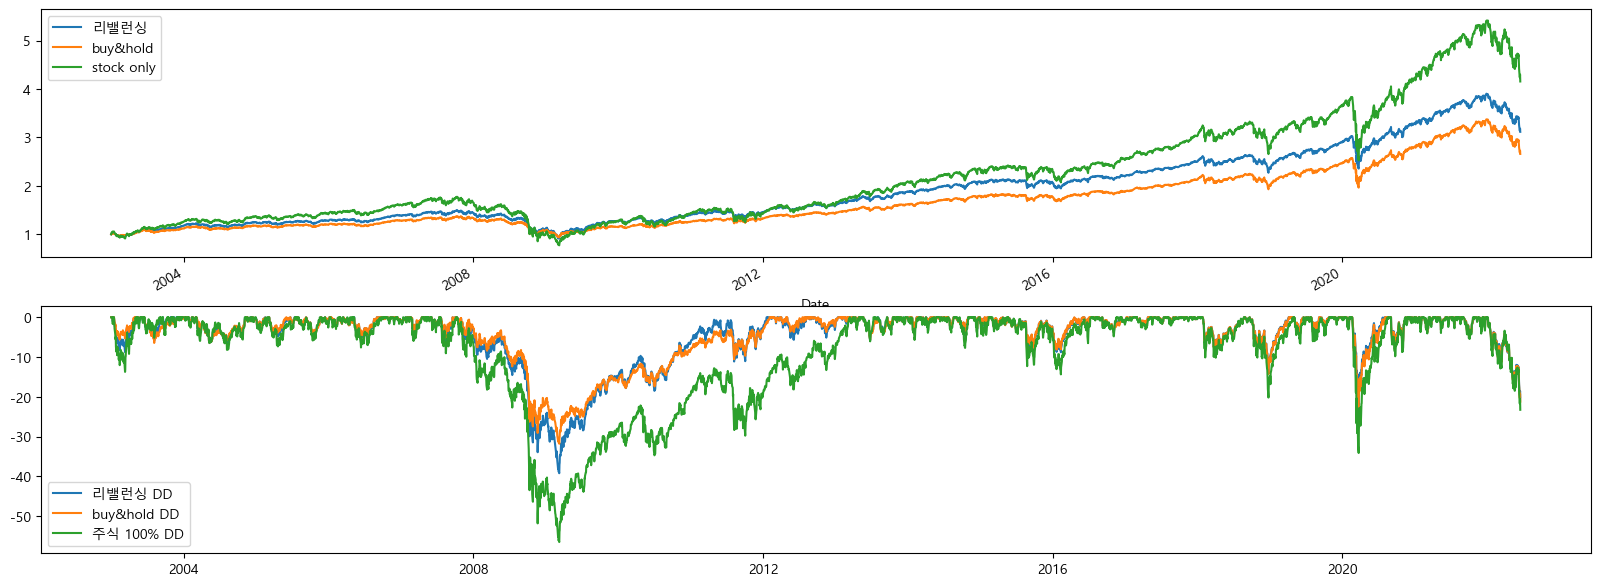

In [44]:
plt.rc('font', family='malgun gothic')
plt.rcParams['axes.unicode_minus'] = False
plt.figure(figsize=(20,8))

# 수익곡선
plt.subplot(2,1,1)
rebalPortfolioCumulativeReturn.plot(label="리밸런싱")
portfolioCumulativeReturn.plot(label="buy&hold")
stockCumReturn.plot(label="stock only")
plt.legend()

# dd 곡선
plt.subplot(2,1,2)
plt.plot(-rebalDD, label="리밸런싱 DD")
plt.plot(-dd, label="buy&hold DD")
plt.plot(-stockDd, label="주식 100% DD")
plt.legend()

plt.show()